In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [ ]:
@nb.njit(parallel=True)
def filter_logcounts(temp_output, logcounts, index_cells, index_genes):
    for i in nb.prange(len(index_cells)):
        temp_output[i] = logcounts[index_cells[i]][index_genes]

In [47]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
index_genes = np.load('./processed_data/single_cell/marker_indices.npy')
feature_index = np.load('./processed_data/single_cell/features_proteincoding_index.npy')
projections = np.load('./processed_data/single_cell/projected_matrix.npy')
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='r+', shape=counts.shape, dtype='float')

In [3]:
# subset
index_all = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)

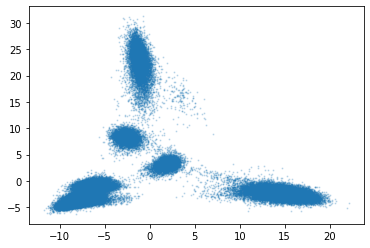

In [4]:
plt.scatter(projections[index_all,0], projections[index_all,1], s=1, alpha=0.2)

In [5]:
# get projections
projections_indexed = projections[index_all]

# metadata
meta_indexed = meta[index_all]
meta_indexed = pd.DataFrame(meta_indexed)
meta_indexed.columns = meta_names
meta_indexed.index = meta_indexed['barcodes']
meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)


/state/partition1/slurm_tmp/23663072.0.0/ipykernel_2906508/4060042172.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)


In [7]:
#L = list(meta_indexed.columns[[x.split('_')[0]=='projid' for x in meta_indexed.columns]])

In [6]:
# batch correction with harmony
from harmony import harmonize

Z = harmonize(projections_indexed, meta_indexed, batch_key = 'seq_batch')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [ ]:
# get markers
marker_temp = np.memmap('./processed_data/single_cell/marker_temp.npy', mode='w+', shape=(np.sum(index_all), len(index_genes)), dtype='float')
filter_logcounts(marker_temp, logcounts, np.where(index_all)[0], index_genes)

In [103]:
markers

,Unnamed: 0,marker,major_celltype
0,Ast.1,ABLIM1,Ast
1,Ast.2,AC002429.2,Ast
2,Ast.3,AC008957.2,Ast
3,Ast.4,AC074363.1,Ast
4,Ast.5,ACOT11,Ast
...,...,...,...
954,Vascular.120,SYNE2,Vascular
955,Vascular.121,TAGLN2,Vascular
956,Vascular.122,TGM2,Vascular
957,Vascular.123,TMEM204,Vascular


In [94]:
# make adata
# features
FEATURES_df = pd.DataFrame(features[index_genes])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

# counts
COUNTS_df = pd.DataFrame(marker_temp)
COUNTS_df.columns = FEATURES_df['Gene']

adata = sc.AnnData(X=COUNTS_df, obs=meta_indexed, var=FEATURES_df)
adata.obsm['X_pca'] = Z
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [95]:
# compute neighborhood graph
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=50)

In [150]:
sc.tl.leiden(adata, resolution=1)

In [157]:
np.unique(adata.obs['leiden'])

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '4', '5', '6', '7', '8', '9'], dtype=object)

In [158]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


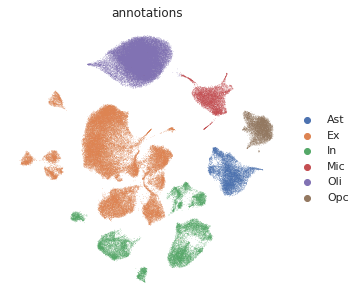

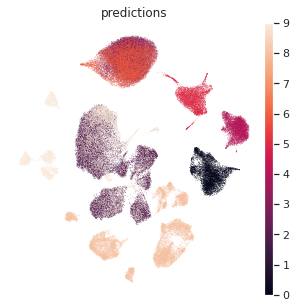

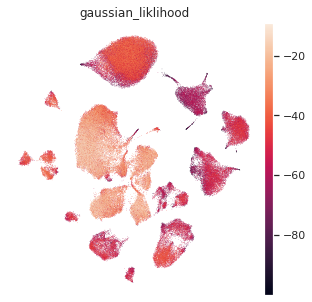

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


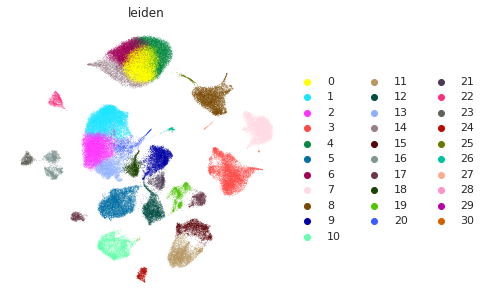

In [159]:
sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['gaussian_liklihood'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [160]:
# rank genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is h

In [193]:
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')


In [194]:
# assign marker scores

scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


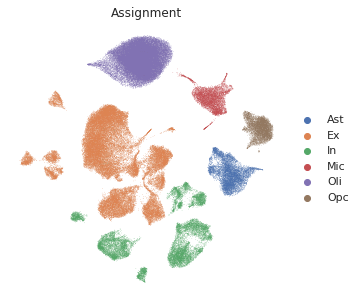

In [195]:
import seaborn as sns
width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [ ]:
# do subclustering, then plot mito and total counts per subcluster and test for vascular enrichments
sc.tl.leiden(adata, resolution=1, restrict_to=('Assignment', ['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc']), key_added='sub_leiden')

In [192]:
adata.obs['sub_leiden']

barcodes
AAACCCAAGTAAACGT-1      Opc
AAACCCACAGAATTCC-1    Ast,9
AAACGAAAGCACGGAT-1       Ex
AAACGAACATTCACAG-1       Ex
AAACGCTTCACCGCTT-1       Ex
                      ...  
TTTCCTCGTTAAGTAG-1       Ex
TTTGCGCCAGCGTTCG-1      Oli
TTTGCGCTCTTACCTA-1       Ex
TTTGGTTAGACACGAC-1      Oli
TTTGGTTCAGGATCGA-1       Ex
Name: sub_leiden, Length: 118668, dtype: category
Categories (20, object): ['Ast,0', 'Ast,1', 'Ast,2', 'Ast,3', ..., 'Lymphoid', 'Mic', 'Oli', 'Opc']

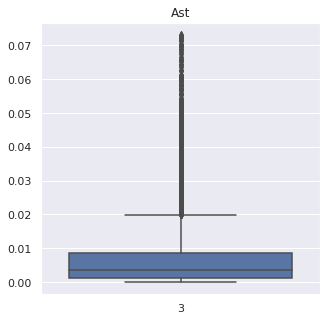

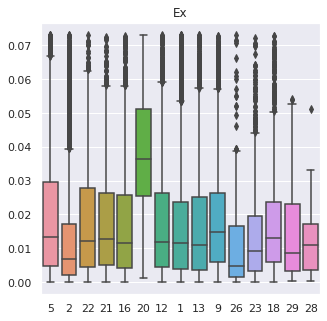

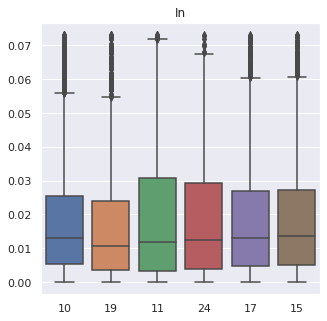

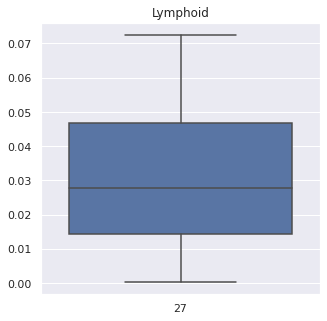

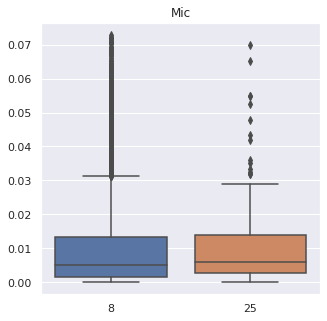

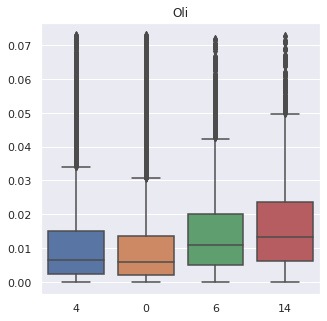

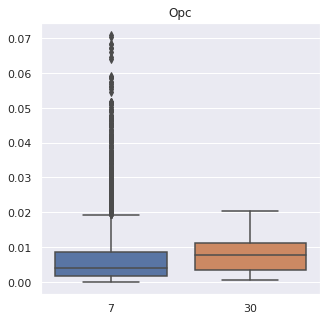

In [186]:
names = adata.obs['Assignment']
for i in np.unique(names):
    index = names==i
    plt.figure(figsize=(5,5))
    sns.boxplot(x=np.array(adata.obs['leiden'])[index], y=np.array(meta_indexed['mito_fractions'])[index])
    plt.title(i)
    plt.show()

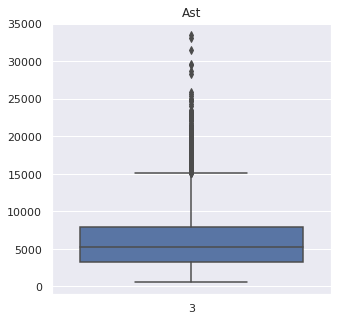

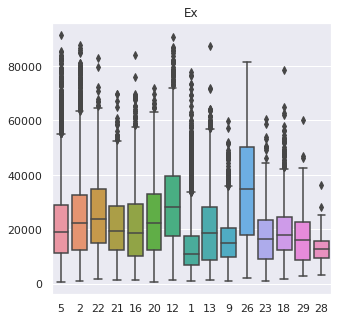

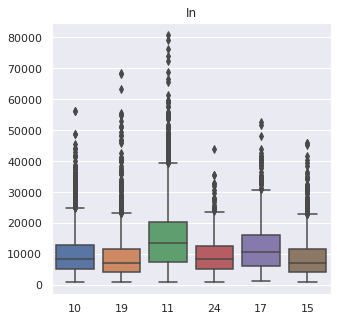

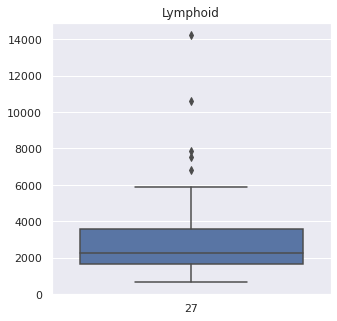

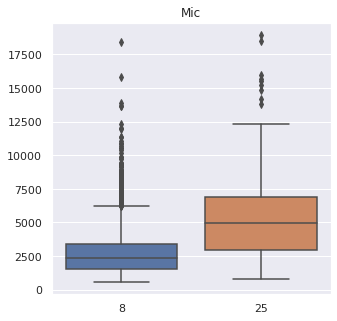

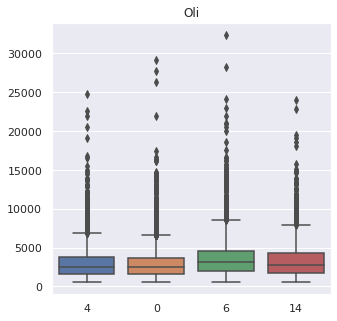

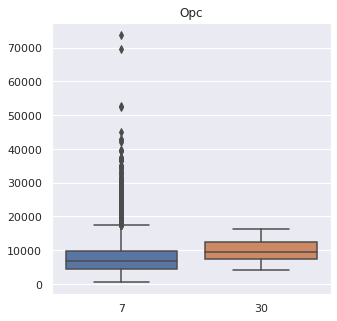

In [187]:
names = adata.obs['Assignment']
for i in np.unique(names):
    index = names==i
    plt.figure(figsize=(5,5))
    sns.boxplot(x=np.array(adata.obs['leiden'])[index], y=np.array(meta_indexed['total_counts'])[index])
    plt.title(i)
    plt.show()

In [169]:
np.unique(adata.obs['Assignment'], return_counts=True)


(array(['Ast', 'Ex', 'In', 'Lymphoid', 'Mic', 'Oli', 'Opc'], dtype=object),
 array([ 8380, 46790, 15998,   109,  6051, 35212,  6128]))

/state/partition1/slurm_tmp/23663072.0.0/ipykernel_2906508/3669272388.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


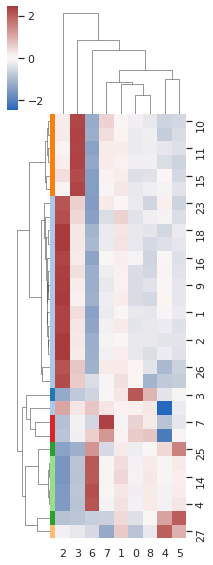

In [170]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

In [34]:
@nb.njit(parallel=True)
def filter_logcounts(temp_output, logcounts, index_cells, index_genes):
    for i in nb.prange(len(index_cells)):
        temp_output[i] = logcounts[index_cells[i]][index_genes]

In [14]:
logcounts.shape

(130727, 36601)

720

In [105]:
adata.layers

Layers with keys: 

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home

In [104]:
# add marker logcounts to adata
adata

AnnData object with n_obs × n_vars = 118668 × 50
    obs: 'barcodes', 'index', 'sample_id', 'molecule_h5', 'study', 'pmi', 'age_death', 'msex', 'amyloid', 'ceradsc', 'nft', 'braaksc', 'cogdx', 'niareagansc', 'ad_reagan', 'apoe_genotype', 'seq_batch', 'individualID', 'WGSid', 'ABCA7LoF', 'TREM2High', 'ABCA1High', 'ADAM10High', 'ATP8B4High', 'SORL1High', 'keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions', 'projid_10101327', 'projid_10222853', 'projid_10248033', 'projid_10290265', 'projid_10485914', 'projid_10490993', 'projid_11200645', 'projid_11240247', 'projid_11302830', 'projid_11310718', 'projid_11336574', 'projid_11345331', 'projid_20112377', 'projid_20173942', 'projid_20201891', 'projid_20282398', 'projid_20366419', 'projid_20875195', 'projid_20978133', 'projid_21000630', 'projid_21138877', 'projid_21159840', 'projid_21172121', 'projid_21189544', 'projid_21405627', 'projid_25300551', 'projid_26569730', 'projid_42988567', 'pro

In [96]:
# assign marker scores

scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gridsan/djuna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


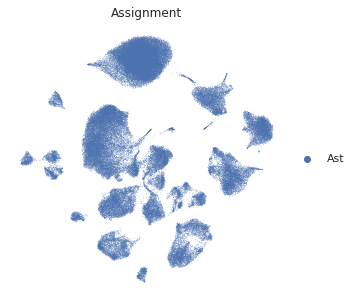

In [97]:
import seaborn as sns
width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [14]:

# metadata
META = meta[index_all]
META_df = pd.DataFrame(META)
META_df.columns = meta_names
META_df.index = META_df['barcodes']
META_df['total_counts'] = META_df['total_counts'].astype(int)
META_df['mito_fractions'] = META_df['mito_fractions'].astype(float)
META_df = pd.get_dummies(META_df, columns=['seq_batch'], drop_first=True)
META_df = pd.get_dummies(META_df, columns=['projid'], drop_first=True)

# features
FEATURES_df = pd.DataFrame(features[index_genes])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

# counts
COUNTS = counts[index_all][:,index_genes]
COUNTS_df = pd.DataFrame(COUNTS)
COUNTS_df.columns = FEATURES_df['Gene']
COUNTS_df.index = META_df['barcodes']

/state/partition1/slurm_tmp/23663072.0.0/ipykernel_2892801/3792335749.py:12: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  META_df = pd.get_dummies(META_df, columns=['projid'], drop_first=True)


In [15]:
# make adata
adata = sc.AnnData(X=COUNTS, obs=META_df, var=FEATURES_df)
adata.uns['metadata'] = META_df
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
# normalize data and choose variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [19]:
L = list(META_df.columns[[x.split('_')[0]=='seq_batch' for x in META_df.columns]])

In [29]:
L = list(META_df['seq_batch_JBM'])

In [32]:
# regress out batch effects
sc.pp.regress_out(adata, 'seq_batch_JBM', n_jobs=94)

KeyboardInterrupt: 

In [8]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [9]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

In [10]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


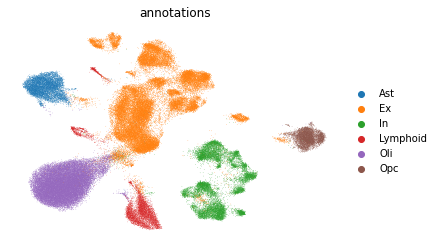

In [11]:
out = sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)
    

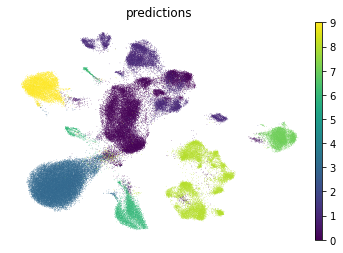

In [12]:
out = sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


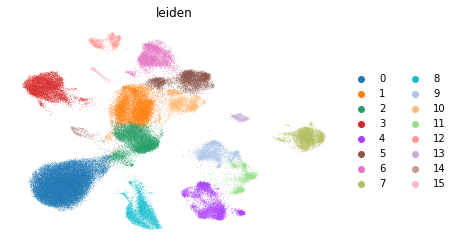

In [13]:
out = sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home

In [21]:
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')
#markers = markers.loc[markers['major_celltype']!='Lymphoid']
markers.head()

,Unnamed: 0,marker,major_celltype
0,Ast.1,ABLIM1,Ast
1,Ast.2,AC002429.2,Ast
2,Ast.3,AC008957.2,Ast
3,Ast.4,AC074363.1,Ast
4,Ast.5,ACOT11,Ast


In [22]:
scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

In [23]:
scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

In [24]:
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


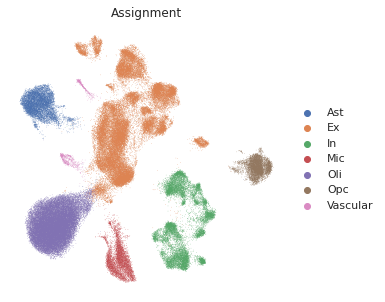

In [25]:
import seaborn as sns
width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [27]:
np.unique(adata.obs['Assignment'], return_counts=True)
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Vascular'], dtype=object),
 array([ 8194, 42911, 14017,  5521, 31099,  5925,  1012]))

In [28]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

/state/partition1/slurm_tmp/23513754.0.0/ipykernel_76704/2153427995.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


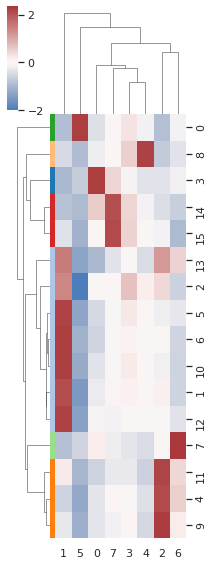

In [29]:
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

In [70]:
keep_genes = np.load('./processed_data/single_cell/keep_genes.npy')
index_genes = np.sum(keep_genes, axis=0)>0
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='float')

In [71]:
# save to sparse matrix (save the new celltype annotations and make sure to subset accordingly)

import scipy.io as sio
from scipy.sparse import csr_matrix

counts_sparse = csr_matrix(counts[index_all][:,index_genes])
logcounts_sparse = csr_matrix(logcounts[index_all][:,index_genes])

sio.mmwrite("./processed_data/single_cell/counts.mtx",counts_sparse)
sio.mmwrite("./processed_data/single_cell/logcounts.mtx",logcounts_sparse)


In [69]:
np.max(logcounts[meta[:,-18]=='171013Tsa',])

0.0

In [62]:
logcounts

(124282, 36601)

In [36]:
# save feature data
df = pd.DataFrame(features[index_genes])
df.to_csv("./processed_data/single_cell/rowData.csv")

In [46]:
celltypes

array(['Ast', 'Ex', 'In', 'Lymphoid', 'Mic', 'Oli', 'Opc', 'Vascular'],
      dtype=object)

In [53]:
# save obs data
df = pd.DataFrame(meta[index_all])
df.columns = meta_names
df['annotations2'] = np.array(adata.obs['Assignment'])
df['leiden_clusters'] = np.array(adata.obs['leiden'])
df['x'] = adata.obsm['X_umap'][:,0]
df['y'] = adata.obsm['X_umap'][:,1]   
df.to_csv("./processed_data/single_cell/colData.csv")

In [48]:
# save celltype score info
df = pd.DataFrame(celltype_scores)
df.columns = celltypes
df.to_csv("./processed_data/single_cell/celltype_scores.csv")

In [54]:
df

,barcodes,index,projid,sample_id,molecule_h5,study,pmi,age_death,msex,amyloid,...,keep_cells_gaussian,predictions,gaussian_liklihood,annotations,total_counts,mito_fractions,annotations2,leiden_clusters,x,y
0,AAACCCAAGTAAACGT-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,7,268.395388,Opc,8992,0.010454,Opc,7,17.002806,4.753179
1,AAACCCACAGAATTCC-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,9,270.337971,Ast,18140,0.003804,Ast,3,-2.643841,11.595880
2,AAACGCTCAGAGTCAG-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,3,258.093871,Oli,560,0.033929,Oli,0,-0.113857,2.885270
3,AAAGAACAGAATACAC-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,3,261.462122,Oli,1866,0.026259,Oli,0,-1.881512,1.998334
4,AACAAGATCAAGATAG-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,9,270.152764,Ast,9326,0.00311,Ast,3,-2.946994,11.175462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108674,TTTCCTCGTTAAGTAG-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,0,274.972967,Ex,36646,0.046226,Ex,10,7.051618,10.256038
108675,TTTGCGCCAGCGTTCG-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,3,252.303667,Oli,940,0.010638,Oli,0,-0.403532,0.824648
108676,TTTGCGCTCTTACCTA-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,1,275.101189,Ex,27804,0.029672,Ex,12,2.231446,15.937909
108677,TTTGGTTAGACACGAC-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,3,270.457027,Oli,2025,0.017284,Oli,0,-2.512164,-0.839972


In [44]:
# np.save('./processed_data/single_cell/annotations.npy', adata.obs['Assignment'])
# np.save('./processed_data/single_cell/leiden.npy', adata.obs['leiden'])
# np.save('./processed_data/single_cell/scores.npy', celltype_scores)

In [20]:
# # save the coordinates
# import numpy as np
# import pandas as pd
# df = pd.DataFrame(np.load('./processed_data/single_cell/coords.npy'))
# df = df.iloc[index_all]
# df['LoF'] = np.array(META_df['ABCA7LoF'])
# df['seq_batch'] = np.array(META_df['seq_batch'])
# df.to_csv('./processed_data/single_cell/coords.csv')

IndexError: Boolean index has wrong length: 124279 instead of 114274